In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch

tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="tokenizer")

string = ["CNV", "DME", "DRUSEN", "Normal"]

inputs = tokenizer(
                string,
                padding="max_length",
                truncation=True,
                max_length=4,
            ).input_ids

print(inputs)

# text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="text_encoder").to("cuda")

# print(text_encoder(torch.tensor(inputs).to("cuda")))

[[49406, 3886, 341, 49407], [49406, 67, 614, 49407], [49406, 2275, 2249, 49407], [49406, 5967, 49407, 0]]


In [5]:
text_encoder_id = "flix-k/custom_model_parts"
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_id, torch_dtype=torch.float16, subfolder="text_encoder_trained")

string = ["NORMAL", "CNV", "DME", "DRUSEN"]

inputs = tokenizer(
                string,
                padding="max_length",
                truncation=True,
                max_length=7,
            ).input_ids

print(inputs)

text_encoder = CLIPTextModel.from_pretrained(text_encoder_id, torch_dtype=torch.float16, subfolder="text_encoder_trained").to("cuda")

print(text_encoder(torch.tensor(inputs).to("cuda")))

[[49406, 5967, 49407, 49407, 49407, 49407, 49407], [49406, 3886, 341, 49407, 49407, 49407, 49407], [49406, 67, 614, 49407, 49407, 49407, 49407], [49406, 2275, 2249, 49407, 49407, 49407, 49407]]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12                                                                                             │
│   13 print(inputs)                                                                               │
│   14                                                                                             │
│ ❱ 15 text_encoder = CLIPTextModel.from_pretrained(text_encoder_id, torch_dtype=torch.float16,    │
│   16                                                                                             │
│   17 print(text_encoder(torch.tensor(inputs).to("cuda")))                                        │
│   18                                                                                             │
│                                                                                                  │
│ /home/flix/anaconda3/envs/xformers/lib/python3.8/site-packages/transformers/modeling_utils.py:21 │
│ 75 in from_pretrained                                                                            │
│                                                                                                  │
│   2172 │   │   # Load config if we don't provide a configuration                                 │
│   2173 │   │   if not isinstance(config, PretrainedConfig):                                      │
│   2174 │   │   │   config_path = config if config is not None else pretrained_model_name_or_pat  │
│ ❱ 2175 │   │   │   config, model_kwargs = cls.config_class.from_pretrained(                      │
│   2176 │   │   │   │   config_path,                                                              │
│   2177 │   │   │   │   cache_dir=cache_dir,                                                      │
│   2178 │   │   │   │   return_unused_kwargs=True,                                                │
│                                                                                                  │
│ /home/flix/anaconda3/envs/xformers/lib/python3.8/site-packages/transformers/models/clip/configur │
│ ation_clip.py:130 in from_pretrained                                                             │
│                                                                                                  │
│   127 │                                                                                          │
│   128 │   @classmethod                                                                           │
│   129 │   def from_pretrained(cls, pretrained_model_name_or_path: Union[str, os.PathLike], **k   │
│ ❱ 130 │   │   config_dict, kwargs = cls.get_config_dict(pretrained_model_name_or_path, **kwarg   │
│   131 │   │                                                                                      │
│   132 │   │   # get the text config dict if we are loading from CLIPConfig                       │
│   133 │   │   if config_dict.get("model_type") == "clip":                                        │
│                                                                                                  │
│ /home/flix/anaconda3/envs/xformers/lib/python3.8/site-packages/transformers/configuration_utils. │
│ py:573 in get_config_dict                                                                        │
│                                                                                                  │
│   570 │   │   """                                                                                │
│   571 │   │   original_kwargs = copy.deepcopy(kwargs)                                            │
│   572 │   │   # Get config dict associated with the base config file                             │
│ ❱ 573 │   │   config_dict, kwargs = cls._get_config_dict(pr

In [ ]:
inputs.to("cuda")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 inputs.to("cuda")                                                                            │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'to'

In [ ]:
input_ids = tokenizer.pad({"input_ids": inputs}, padding=True, return_tensors="pt").input_ids
print(input_ids.shape)

torch.Size([2, 4])


In [ ]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import torch
import matplotlib.pyplot as plt

from torch import nn

from transformers import CLIPTextModel, CLIPTokenizer, CLIPModel

from diffusers import DDPMScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler

euler_a = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="scheduler")
multi_dpm = DPMSolverMultistepScheduler.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="scheduler")



model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained(model_id, torch_dtype=torch.float16, subfolder="unet").to("cuda")

            # unet.enable_gradient_checkpointing()

unet.half()  # convert to half precision

for layer in unet.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
    if isinstance(layer, nn.GroupNorm):
        layer.float()
    if isinstance(layer, nn.LayerNorm):
        layer.float()

pipe.unet = unet

text_encoder_id = "flix-k/custom_model_parts"
text_encoder = CLIPTextModel.from_pretrained(text_encoder_id, torch_dtype=torch.float16, subfolder="text_encoder_trained").to("cuda")
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_id, torch_dtype=torch.float16, subfolder="text_encoder_trained")

pipe.text_encoder = text_encoder
pipe.tokenizer = tokenizer
pipe.scheduler = euler_a



Some weights of the model checkpoint at flix-k/custom_model_parts were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.25.self_attn.v_proj.weight', 'vision_model.encoder.layers.13.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.9.layer_norm2.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.26.mlp.fc2.weight', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.22.mlp.fc1.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.self_attn

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:  CNV


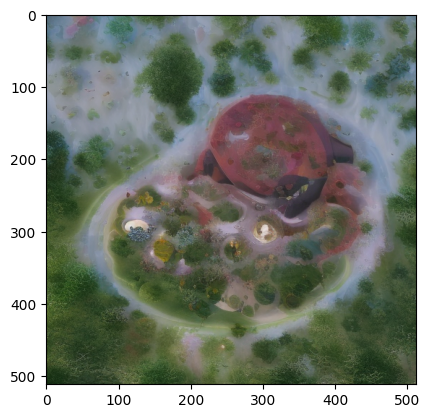

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:  DME


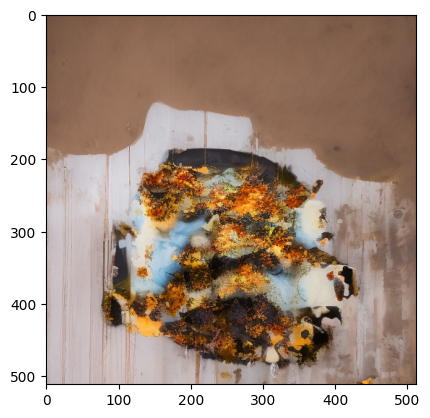

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:  DRUSEN


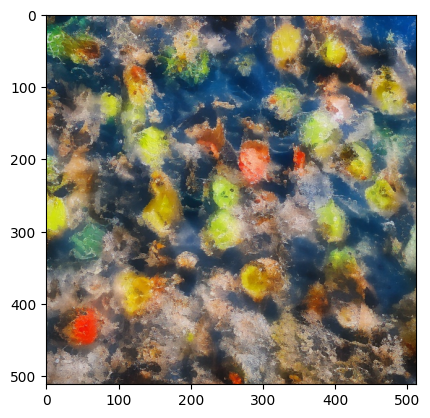

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:  NORMAL


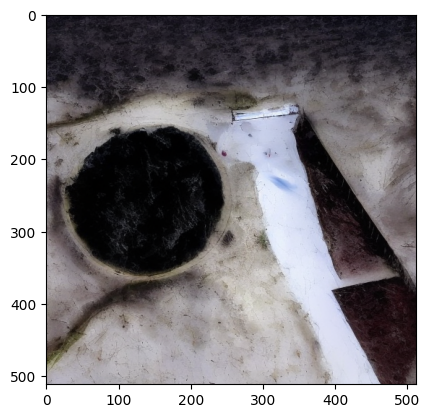

In [ ]:
prompt = "CNV"
for class_prompt in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    with torch.autocast("cuda"):
        images = pipe(
            prompt = class_prompt,
            num_inference_steps = 50,
            ).images

    print("Prompt: ", class_prompt)
    plt.imshow(images[0])
    plt.show()

EulerAncestralDiscreteScheduler {
  "_class_name": "EulerAncestralDiscreteScheduler",
  "_diffusers_version": "0.16.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.16.0.dev0",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 1,
  "thresholding": false,
  "trained_betas": null,
  "use_karras_sigmas": false
}

In [1]:
from diffusion_modules.pickled_dataset import PickleFolder
from diffusion_modules.pickled_dataset import collate_fn
import torch

classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

dataset = PickleFolder(root="./utils/latents/train/", transform=None, target_transform=None, samples_per_class=25, classes_to_use=["CNV", "DME"])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)


print(dataset[0])

for batch in dataloader:
    class_ = batch["classes"]
    print(classes[class_[0]])

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.0+cu118 with CUDA 1108 (you have 1.13.0+cu116)
    Python  3.8.16 (you have 3.8.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2023-06-03 22:10:38.198390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 22:10:38.276202: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the

{'latents': <diffusers.models.vae.DiagonalGaussianDistribution object at 0x7f04226f0d00>, 'target': 0}
CNV
CNV
CNV
CNV
DME
DME
DME
DME
CNV
DME
CNV
CNV
DME
DME
DME
DME
DME
CNV
CNV
DME
DME
CNV
DME
CNV
CNV
CNV
DME
DME
CNV
DME
DME
DME
CNV
DME
DME
CNV
CNV
DME
CNV
CNV
CNV
CNV
DME
CNV
DME
CNV
DME
CNV
CNV
DME


In [19]:
import os
import random
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from pytorch_msssim import ms_ssim
from tqdm import tqdm


def calculate_intra_class_variance(directory, num_pairs):
    # Get list of image paths
    image_paths = [os.path.join(directory, name) for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))]

    msssim_values = []
    for _ in tqdm(range(num_pairs)):
        # Randomly select two image paths
        img_path1, img_path2 = random.sample(image_paths, 2)

        # Convert image paths to tensors
        img1 = ToTensor()(Image.open(img_path1)).unsqueeze(0)  # add a batch dimension
        img2 = ToTensor()(Image.open(img_path2)).unsqueeze(0)  # add a batch dimension

        # Calculate MS-SSIM
        msssim = ms_ssim(img1, img2, data_range=1, size_average=True)
        msssim_values.append(msssim.item())

    # Variance of MS-SSIM values
    mean_msssim = torch.tensor(msssim_values).mean().item()
    return mean_msssim

def calculate_intra_class_variance2(directory, num_pairs):
    # Get list of image paths
    image_paths = [os.path.join(directory, name) for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))]

    X, Y = [], []
    for _ in range(num_pairs):
        # Randomly select two image paths
        img_path1, img_path2 = random.sample(image_paths, 2)

        # Convert image paths to tensors and add a batch dimension
        img1 = ToTensor()(Image.open(img_path1).convert("RGB")).unsqueeze(0)
        img2 = ToTensor()(Image.open(img_path2).convert("RGB")).unsqueeze(0)

        X.append(img1)
        Y.append(img2)

    # Stack all image pairs to form a tensor of shape (N, 3, H, W)
    X = torch.cat(X)
    Y = torch.cat(Y)

    # Calculate MS-SSIM for all pairs at once
    msssim_values = ms_ssim(X, Y, data_range=1, size_average=True)

    # Mean of MS-SSIM values
    mean_msssim = msssim_values.mean().item()

    return mean_msssim
def calculate_inter_class_mean_msssim(directory1, directory2, num_pairs):
    # Get list of image paths
    image_paths1 = [os.path.join(directory1, name) for name in os.listdir(directory1) if os.path.isfile(os.path.join(directory1, name))]
    image_paths2 = [os.path.join(directory2, name) for name in os.listdir(directory2) if os.path.isfile(os.path.join(directory2, name))]

    msssim_values = []
    for _ in range(num_pairs):
        # Randomly select an image path from each directory
        img_path1 = random.choice(image_paths1)
        img_path2 = random.choice(image_paths2)

        # Convert image paths to tensors
        img1 = ToTensor()(Image.open(img_path1)).unsqueeze(0)  # add a batch dimension
        img2 = ToTensor()(Image.open(img_path2)).unsqueeze(0)  # add a batch dimension

        # Calculate MS-SSIM
        msssim = ms_ssim(img1, img2, data_range=1, size_average=True)
        msssim_values.append(msssim.item())

    # Mean of MS-SSIM values
    mean_msssim = torch.tensor(msssim_values).mean().item()
    return mean_msssim


In [20]:
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
for class_ in classes:
    variance = calculate_intra_class_variance(f"/home/flix/Documents/oct-data/CellData/OCT_resized/train/{class_}/", 100)
    print(f"{class_}-MSSSIM",variance)

100%|██████████| 100/100 [00:00<00:00, 104.01it/s]


CNV-MSSSIM 0.3343753516674042


100%|██████████| 100/100 [00:00<00:00, 113.77it/s]


DME-MSSSIM 0.3270411789417267


100%|██████████| 100/100 [00:00<00:00, 102.16it/s]


DRUSEN-MSSSIM 0.3429776728153229


100%|██████████| 100/100 [00:01<00:00, 97.26it/s]

NORMAL-MSSSIM 0.3850864768028259


In [32]:
import pandas as pd

# Initialize an empty DataFrame
df = pd.DataFrame(columns=classes, index=classes)

classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
for class1 in classes:
    for class2 in classes:
        variance = calculate_inter_class_mean_msssim(
              f"/home/flix/Documents/oct-data/CellData/OCT_resized/train/{class1}/",
              f"/home/flix/Documents/oct-data/CellData/OCT_resized/train/{class2}/",
              1000)
        df.loc[class1, class2] = variance


In [33]:
# Print the DataFrame
print(df)

             CNV       DME    DRUSEN    NORMAL
CNV     0.321048  0.322093  0.332241  0.337993
DME     0.317135  0.317553  0.342009  0.344691
DRUSEN  0.329744  0.334828  0.346801    0.3605
NORMAL  0.333458  0.341524  0.361488  0.372841


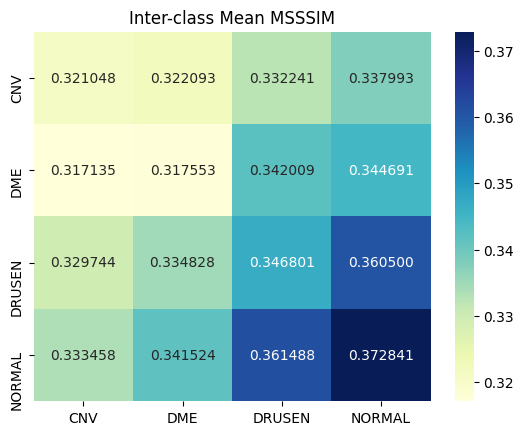

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.astype(float)

# Display the DataFrame as a heatmap
sns.heatmap(df, annot=True, fmt=".6f", cmap="YlGnBu")
plt.title("Inter-class Mean MSSSIM")
plt.show()


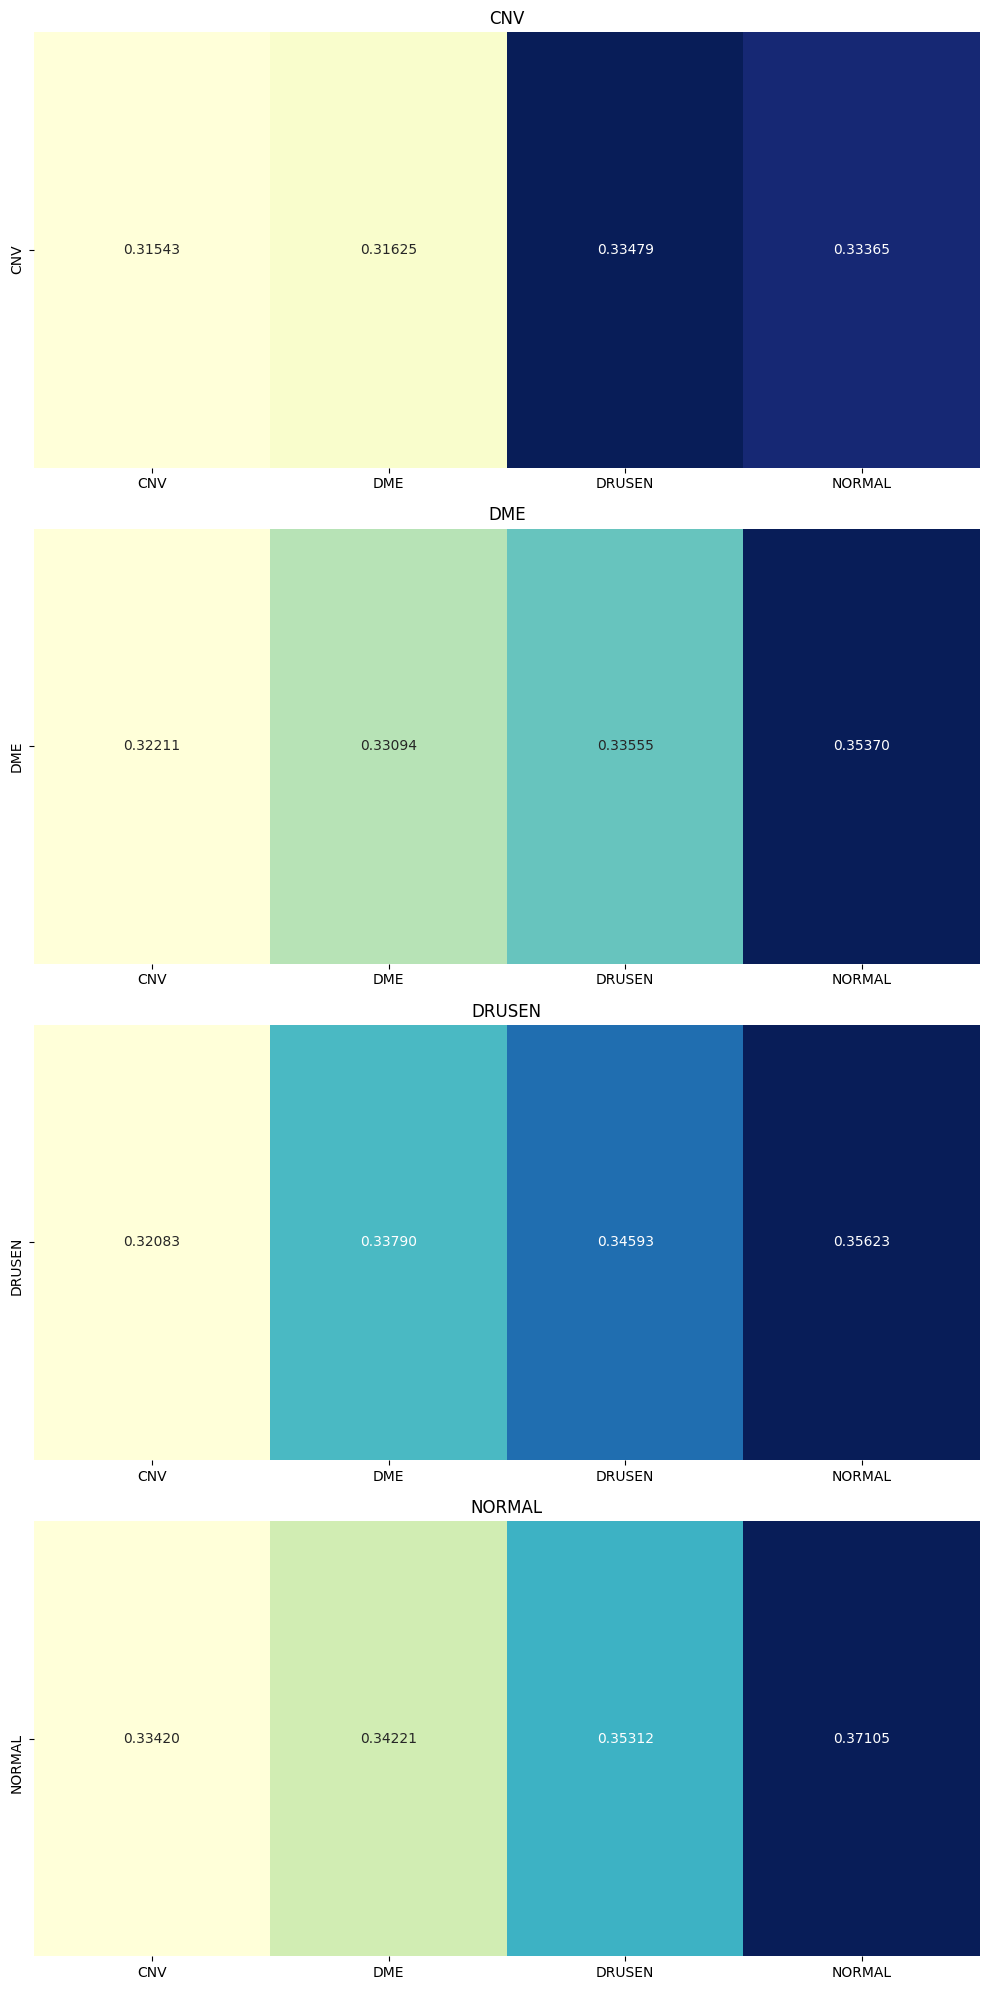

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a figure with a subplot for each row
fig, axs = plt.subplots(len(df), 1, figsize=(10, 20))

for i, (idx, row) in enumerate(df.iterrows()):
    # Reshape the row to be a 1xN DataFrame and plot it as a heatmap
    sns.heatmap(pd.DataFrame(row).T, annot=True, fmt=".5f", cmap="YlGnBu", cbar=False, ax=axs[i])
    axs[i].set_title(idx)

# Show the plot
plt.tight_layout()
plt.show()


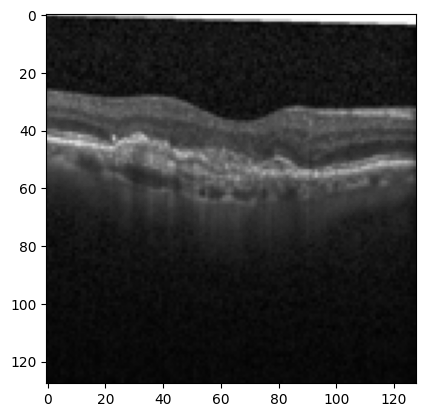

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open('/home/flix/Documents/oct-data/CellData/OCT_resized/train/CNV/CNV-1016042-1.jpeg')

resolution = 128

# Resize the image
resized_img = img.resize((resolution, resolution))

# Display the image
plt.imshow(resized_img, cmap="gray")
plt.show()
